In [118]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import betaln, binom
from scipy.stats import beta as betadist
import seaborn as sns
import pandas as pd

np.set_printoptions(suppress=True)

# Beta-Binomial (2 Models)

## Helpers

In [119]:
def beta_binom(prior, y):
    """
    Compute the marginal likelihood, analytically, for a beta-binomial model.

    prior : tuple
        tuple of alpha and beta parameter for the prior (beta distribution)
    y : array
        array with "1" and "0" corresponding to the success and fails respectively
    """
    
    alpha, beta = prior
    h = np.sum(y)
    n = len(y)
    p_y = binom(n, h) * np.exp(betaln(alpha + h, beta + n - h) - betaln(alpha, beta))
    return p_y

def prior(pars):
    """Generates a random draw from the beta prior."""
    return betadist(pars[0], pars[1]).rvs()

def model(theta, n=50):
    """Implements the binomial likelihood with a single parameter `theta`."""
    return np.random.binomial(n=1, p=theta, size=n)

def pmp(y, m_idx):
    """Computes PMPs for a given model index."""
    
    p = 0.5 * beta_binom(prior_pars[m_idx], y)
    p = p / (0.5 * beta_binom(prior_pars[0], y) + 0.5 * beta_binom(prior_pars[1], y))
    return (p, 1 - p)

def mom(d):
    """Method of moments estimator for alpha and beta given an array of data `d`."""
    s_mean = np.mean(d)
    s_var = np.var(d, ddof=1)
    alpha = s_mean * (s_mean*(1 - s_mean) / s_var - 1)
    beta = (1 - s_mean) * (s_mean*(1 - s_mean) / s_var - 1)
    return alpha, beta

# Setup

## Parameter Priors

In [123]:
colors = ['#472D7B', '#75D054']

In [124]:
# Represents alpha and beta params for the beta priors
prior_pars = ((1, 10), (1, 20))

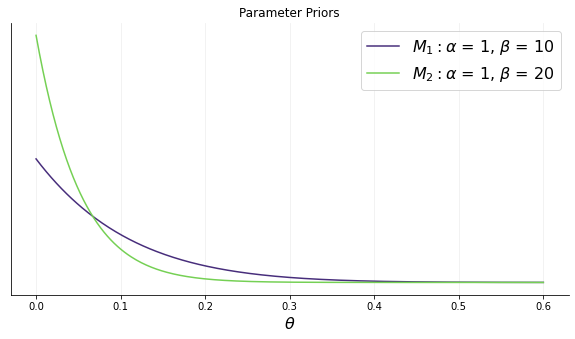

In [125]:
f, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
for i, (a, b) in enumerate(prior_pars):
    distri = betadist(a, b)
    x = np.linspace(0, 0.6, 300)
    x_pdf = distri.pdf(x)
    ax.plot(x, x_pdf, label=fr"$M_{i+1}: \alpha$ = {a:d}, $\beta$ = {b:d}", color=colors[i])
    ax.set_yticks([])
    ax.set_xlabel("$\\theta$", fontsize=16)
    ax.legend(fontsize=16)
ax.set_title('Parameter Priors')
ax.grid(alpha=0.2)
sns.despine()

## Model-Implied Data and PMPs

In [ ]:
n_sim = 5000
n_obs = 50
pmps = {
    0: [],
    1: []
}
mls = {
    0: [],
    1: []
}
for n in range(n_sim):
    m = np.random.randint(0, 2)
    y = model(prior(prior_pars[m]), n=n_obs)
    post_probs = pmp(y, m)
    pmps[m].append(post_probs)
    mls[m].append((np.sum(y), beta_binom(prior_pars[m], y)))

# Convert to arrays
pmps[0] = np.array(pmps[0])
pmps[1] = np.array(pmps[1])

mls[0] = np.array(mls[0])
mls[1] = np.array(mls[1])

## Model-Implied PMP Distributions

In [ ]:
f, axarr = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
cols = []
for i in range(2):
    sns.kdeplot(pmps[i][:, 0], ax=axarr[i], color='#5345ad', alpha=0.9, fill=True, label=r'$p(M_1\,|\,y)$')
    sns.kdeplot(pmps[i][:, 1], ax=axarr[i], color='#ad4545', alpha=0.9, fill=True, label=r'$p(M_2\,|\,y)$')
    axarr[i].set_title(r'PMP Distribution $M^* = {}$'.format(i+1), fontsize=18)
    sns.despine(ax=axarr[i])
    axarr[i].grid(alpha=0.1)
    axarr[i].legend(fontsize=16)
f.tight_layout()

## Marginal Likelihoods

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)

# M 1
idx = np.argsort(mls[0][:, 0])
ax.plot(mls[0][idx, 0], mls[0][idx, 1], color=colors[0], label=r'$p(y\,|\,M_1)$')

# M 2
idx = np.argsort(mls[1][:, 0])
ax.plot(mls[1][idx, 0], mls[1][idx, 1], color=colors[1], label=r'$p(y\,|\,M_2)$')

# Schmuck
sns.despine(ax=ax)
ax.legend(fontsize=16)
ax.set_yticks([])
ax.set_xlabel('# successes', fontsize=16)
ax.set_title('Marginal Likelihoods', fontsize=18)
ax.grid(alpha=0.3)

## Meta-Models
Using MLE, since too lazy to do Bayesian and number of simulations anyway large, hence predictive distribution $\approx$ likelihood with MLE estimates.

In [ ]:
# MLE of meta models
alpha1, beta1 = mom(pmps[0][:, 0])
alpha2, beta2 = mom(pmps[1][:, 0])
mean1 = betadist(alpha1, beta1).mean()
mean2 = betadist(alpha2, beta2).mean()
matrix_pmp = np.array([[mean1, 1 - mean2], [1 - mean1, mean2]])

In [ ]:
print(matrix_pmp)

## Overconfidence and Unusual Data

In [ ]:
# Unusual data
y = np.repeat([0, 1], [10, 40])

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)

# M 1
idx = np.argsort(mls[0][:, 0])
ax.plot(mls[0][idx, 0], mls[0][idx, 1], color=colors[0], label=r'$p(y\,|\,M_1)$')

# M 2
idx = np.argsort(mls[1][:, 0])
ax.plot(mls[1][idx, 0], mls[1][idx, 1], color=colors[1], label=r'$p(y\,|\,M_2)$')

# Data
ax.axvline(np.sum(y), color='black', linestyle='dashed', label='Data')

# Schmuck
sns.despine(ax=ax)
ax.set_yticks([])
ax.set_xlabel('# successes', fontsize=16)
ax.grid(alpha=0.3)
ax.legend(fontsize=16)

In [ ]:
# Observed PMP, Lol
pmp_obs = pmp(y, 0)
print(pmp_obs)

In [ ]:
# Simulation-based Correction
matrix_pmp @ pmp_obs

# Beta-Binomial (3 Models)

## Helpers

In [96]:
def pmp(y, m_idx):
    """Computes PMPs for a given model index."""
    
    p = beta_binom(prior_pars[m_idx], y) / 3
    norm_c = sum([beta_binom(prior_pars[i], y) for i in range(3)]) / 3
    return p / norm_c

In [97]:
colors = ['#440154', '#2A788E', '#75D054']

In [98]:
# Represents alpha and beta params for the beta priors
prior_pars = ((2, 10), (2, 20), (2, 100))

## Parameter Priors
Note, that model 2 can almost NEVER win, since it is sandwitched by the two other models.

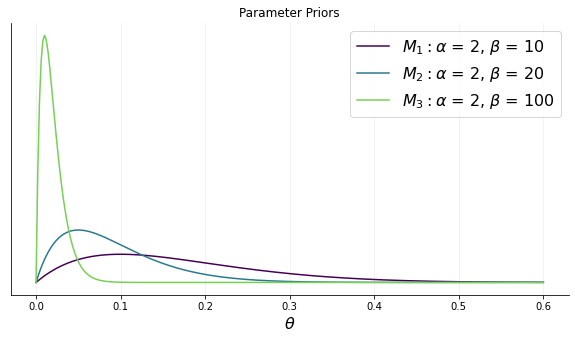

In [99]:
f, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
for i, (a, b) in enumerate(prior_pars):
    distri = betadist(a, b)
    x = np.linspace(0, 0.6, 300)
    x_pdf = distri.pdf(x)
    ax.plot(x, x_pdf, label=fr"$M_{i+1}: \alpha$ = {a:d}, $\beta$ = {b:d}", color=colors[i])
    ax.set_yticks([])
    ax.set_xlabel("$\\theta$", fontsize=16)
    ax.legend(fontsize=16)
ax.set_title('Parameter Priors')
ax.grid(alpha=0.2)
sns.despine()

## Model-Implied Data

In [114]:
n_sim = 1000
n_obs = 500
pmps = {
    0: [],
    1: [],
    2: []
}
mls = {
    0: [],
    1: [],
    2: []
}
for _ in range(n_sim):
    m = np.random.randint(0, 3)
    y = model(prior(prior_pars[m]), n=n_obs)
    post_probs = [pmp(y, i) for i in range(3)]
    pmps[m].append(post_probs)
    mls[m].append((np.sum(y), beta_binom(prior_pars[m], y)))

for i in range(3):
    pmps[i] = np.array(pmps[i])
    mls[i] = np.array(mls[i])

## Model-Implied PMP Distributions

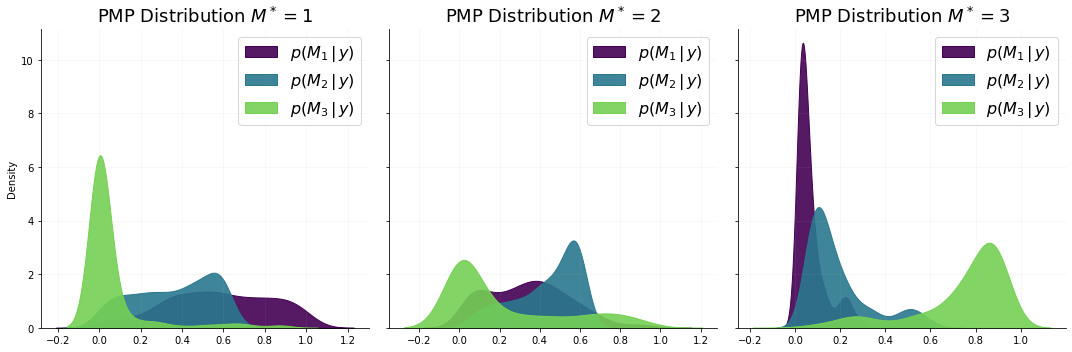

In [115]:
f, axarr = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
cols = []
for i in range(3):
    sns.kdeplot(pmps[i][:, 0], ax=axarr[i], color=colors[0], alpha=0.9, fill=True, label=r'$p(M_1\,|\,y)$')
    sns.kdeplot(pmps[i][:, 1], ax=axarr[i], color=colors[1], alpha=0.9, fill=True, label=r'$p(M_2\,|\,y)$')
    sns.kdeplot(pmps[i][:, 2], ax=axarr[i], color=colors[2], alpha=0.9, fill=True, label=r'$p(M_3\,|\,y)$')
    axarr[i].set_title(r'PMP Distribution $M^* = {}$'.format(i+1), fontsize=18)
    sns.despine(ax=axarr[i])
    axarr[i].grid(alpha=0.1)
    axarr[i].legend(fontsize=16)
f.tight_layout()

## Marginal Likelihoods

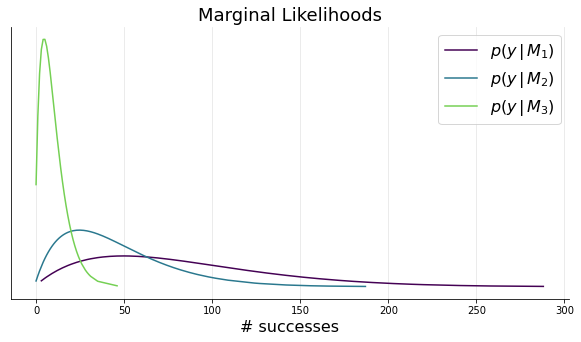

In [116]:
f, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)

# M 1
idx = np.argsort(mls[0][:, 0])
ax.plot(mls[0][idx, 0], mls[0][idx, 1], color=colors[0], label=r'$p(y\,|\,M_1)$')

# M 2
idx = np.argsort(mls[1][:, 0])
ax.plot(mls[1][idx, 0], mls[1][idx, 1], color=colors[1], label=r'$p(y\,|\,M_2)$')

# M 3
idx = np.argsort(mls[2][:, 0])
ax.plot(mls[2][idx, 0], mls[2][idx, 1], color=colors[2], label=r'$p(y\,|\,M_3)$')

# Schmuck
sns.despine(ax=ax)
ax.legend(fontsize=16)
ax.set_yticks([])
ax.set_xlabel('# successes', fontsize=16)
ax.set_title('Marginal Likelihoods', fontsize=18)
ax.grid(alpha=0.3)

## Meta-Models

In [117]:
df_1 = pd.DataFrame(pmps[0], columns = ["pmp1", "pmp2", "pmp3"])
df_2 = pd.DataFrame(pmps[1], columns = ["pmp1", "pmp2", "pmp3"])
df_3 = pd.DataFrame(pmps[2], columns = ["pmp1", "pmp2", "pmp3"])

df_1.insert(loc=0, column="true_model_idx", value=1)
df_2.insert(loc=0, column="true_model_idx", value=2)
df_3.insert(loc=0, column="true_model_idx", value=3)

df = pd.concat([df_1, df_2, df_3], ignore_index=True)

df.to_csv("../output/computations/beta_binomial_pmps.csv")

df

,true_model_idx,pmp1,pmp2,pmp3
0,1,0.867059,0.132941,2.248800e-10
1,1,0.489837,0.509281,8.817368e-04
2,1,0.528987,0.470750,2.622811e-04
3,1,0.348187,0.606301,4.551123e-02
4,1,0.961444,0.038556,4.695883e-15
...,...,...,...,...
995,3,0.067353,0.199298,7.333490e-01
996,3,0.022151,0.076737,9.011116e-01
997,3,0.051964,0.159981,7.880544e-01
998,3,0.025684,0.087253,8.870630e-01


In [84]:
# Quick and dirty MLE of Dirichlet means (replace with Bayes)
p_m1 = np.mean(pmps[0], axis=0)
p_m2 = np.mean(pmps[1], axis=0)
p_m3 = np.mean(pmps[2], axis=0)

matrix_pmp = np.array([p_m1, p_m2, p_m3])

In [85]:
print(matrix_pmp)

[[0.41149504 0.16063858 0.42786638]
 [0.16175069 0.78618755 0.05206176]
 [0.42235302 0.05550351 0.52214346]]


## Overconfidence and Unusual Data

In [21]:
# Unusual data
y = np.repeat([0, 1], [10, 40])

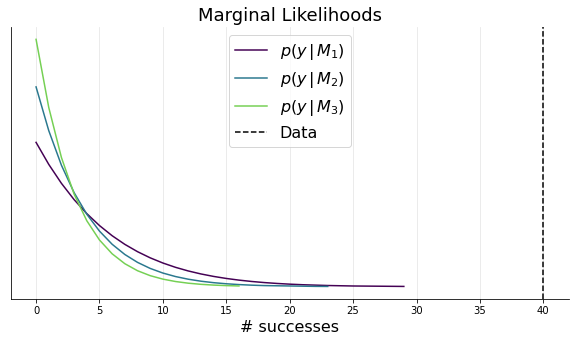

In [22]:
f, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)

# M 1
idx = np.argsort(mls[0][:, 0])
ax.plot(mls[0][idx, 0], mls[0][idx, 1], color=colors[0], label=r'$p(y\,|\,M_1)$')

# M 2
idx = np.argsort(mls[1][:, 0])
ax.plot(mls[1][idx, 0], mls[1][idx, 1], color=colors[1], label=r'$p(y\,|\,M_2)$')

# M 3
idx = np.argsort(mls[2][:, 0])
ax.plot(mls[2][idx, 0], mls[2][idx, 1], color=colors[2], label=r'$p(y\,|\,M_3)$')

# Data
ax.axvline(np.sum(y), color='black', linestyle='dashed', label='Data')

# Schmuck
sns.despine(ax=ax)
ax.legend(fontsize=16)
ax.set_yticks([])
ax.set_xlabel('# successes', fontsize=16)
ax.set_title('Marginal Likelihoods', fontsize=18)
ax.grid(alpha=0.3)

In [23]:
# Observed PMP, Lol
pmp_obs = np.array([pmp(y, i) for i in range(3)])
print('Observed PMPs: ', pmp_obs)

Observed PMPs:  [0.99224094 0.00765886 0.0001002 ]


In [24]:
# Simulation-based Correction
matrix_pmp @ pmp_obs

array([0.36603842, 0.32332886, 0.30746684])